In [677]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import pickle
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from scipy.sparse import hstack
from datetime import datetime

In [678]:
df = pd.read_csv('cleaned_dataset.csv')
df.head()

,question_id,title,content,difficulty,likes,dislikes,similar_questions,topic_tags,hints,topic,totalAccepted,totalSubmission,acRate
0,540,singl element sort array,given sort array consist integ everi element a...,Medium,4873,110,[],Array Binary Search,singl element sort array,Algorithms,281300,479400,58.7
1,919,project area 3d shape,given grid place cube axi align axe valu grid ...,Easy,387,1135,[],Array Math Geometry Matrix,project area 3d shape,Algorithms,39800,56900,69.9
2,493,revers pair,given integ array num return number revers pai...,Hard,2641,176,"['Count of Smaller Numbers After Self', 'Count...",Array Binary Search Divide and Conquer Binary ...,revers pair,Algorithms,79500,266800,29.8
3,2045,cut ribbon,cut ribbon,Medium,340,20,"['Capacity To Ship Packages Within D Days', 'A...",Array Binary Search,use binari search answer can get branch length...,Algorithms,34100,70800,48.1
4,2141,smallest greater multipl made two digit,smallest greater multipl made two digit,Medium,18,3,[],Math Enumeration,could generat differ number compris digit1 dig...,Algorithms,864,1600,52.4


In [679]:
df.isnull().sum()

question_id          0
title                0
content              0
difficulty           0
likes                0
dislikes             0
similar_questions    0
topic_tags           0
hints                0
topic                0
totalAccepted        0
totalSubmission      0
acRate               0
dtype: int64

In [680]:
#since the dataset is limited hence instead of using all the tags I will filter only the most important tags and train model on it
#check the number of topic tags and the data coverage

In [681]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(df['topic_tags'])

In [682]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [683]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=df.shape[0]
for i in range(0, total_tags, 12):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

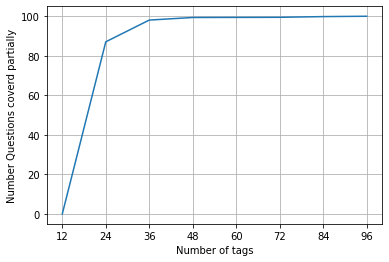

with  48 tags we are covering  100.0 % of questions


In [684]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(0+np.array(range(0,92,3))*4)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
print("with ",48,"tags we are covering ",questions_explained[7],"% of questions")

In [685]:
multilabel_yx = tags_to_choose(48)
print("number of questions that are not covered :", questions_explained_fn(48),"out of ", total_qs)

number of questions that are not covered : 13 out of  2219


In [686]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 92
number of tags taken : 48 ( 52.17391304347826 %)


In [687]:
#split the data into train and test 
total_size=df.shape[0]
#performing a 90:10 split
train_size=int(0.90*total_size)

x_train=df.head(train_size)
x_test=df.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

# Featurizations

<h3> one hot encoding </h3>

In [688]:
#one hot encoding the categorical feature- difficulty
vectorizer = CountVectorizer()
vectorizer.fit(x_train['difficulty'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_difficulty = vectorizer.transform(x_train['difficulty'].values)
x_test_difficulty = vectorizer.transform(x_test['difficulty'].values)

#one hot encoding the categorical feature- difficulty
vectorizer = CountVectorizer()
vectorizer.fit(x_train['topic'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_topic = vectorizer.transform(x_train['topic'].values)
x_test_topic = vectorizer.transform(x_test['topic'].values)

<h3> MinMax Scaler </h3>

In [689]:
#standardising the numerical values using MinMax scaler

#standardising likes
scaler = MinMaxScaler()
scaler.fit(x_train['likes'].values.reshape(-1, 1))
x_train_likes = scaler.transform(x_train['likes'].values.reshape(-1, 1))
x_test_likes = scaler.transform(x_test['likes'].values.reshape(-1, 1))

#standardising dislikes
scaler = MinMaxScaler()
scaler.fit(x_train['dislikes'].values.reshape(-1, 1))
x_train_dislikes = scaler.transform(x_train['dislikes'].values.reshape(-1, 1))
x_test_dislikes = scaler.transform(x_test['dislikes'].values.reshape(-1, 1))

#standardising totalAccepted
scaler = MinMaxScaler()
scaler.fit(x_train['totalAccepted'].values.reshape(-1, 1))
x_train_accepted = scaler.transform(x_train['totalAccepted'].values.reshape(-1, 1))
x_test_accepted = scaler.transform(x_test['totalAccepted'].values.reshape(-1, 1))

#standardising totalSubmission
scaler = MinMaxScaler()
scaler.fit(x_train['totalSubmission'].values.reshape(-1, 1))
x_train_submission = scaler.transform(x_train['totalSubmission'].values.reshape(-1, 1))
x_test_submission = scaler.transform(x_test['totalSubmission'].values.reshape(-1, 1))

#standardising acRate
scaler = MinMaxScaler()
scaler.fit(x_train['acRate'].values.reshape(-1, 1))
x_train_acRate = scaler.transform(x_train['acRate'].values.reshape(-1, 1))
x_test_acRate = scaler.transform(x_test['acRate'].values.reshape(-1, 1))

In [690]:
#drop similar questions column
x_train.drop('similar_questions', axis=1, inplace=True)
x_test.drop('similar_questions', axis=1, inplace=True)

<h3> TF-IDF Vectorization</h3>
- creating text vectorizations for each column seperately and then concatenating the features

In [691]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.0009, max_features=300, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))

x_train_tfidf_title = vectorizer.fit_transform(x_train['title'])
x_test_tfidf_title = vectorizer.transform(x_test['title'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:00.051194


In [692]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.0009, max_features=400, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))

x_train_tfidf_content = vectorizer.fit_transform(x_train['content'])
x_test_tfidf_content = vectorizer.transform(x_test['content'] )
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:00.340958


In [693]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.0009, max_features=350, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))

x_train_tfidf_hints = vectorizer.fit_transform(x_train['hints'])
x_test_tfidf_hints = vectorizer.transform(x_test['hints'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:00.152002


In [694]:
# #stacking all the featurizations created above into a single array
# X_tr = hstack((x_train_tfidf, x_train_likes, x_train_dislikes, x_train_accepted, x_train_submission,
#                x_train_acRate, x_train_topic, x_train_difficulty)).tocsr()

# X_te = hstack((x_test_tfidf, x_test_likes, x_test_dislikes, x_test_accepted, x_test_submission,
#                x_test_acRate, x_test_topic, x_test_difficulty)).tocsr()
# print(X_tr.shape, y_train.shape)
# print(X_te.shape, y_test.shape)

In [695]:
#stacking all the featurizations created above into a single array
X_tr = hstack((x_train_tfidf_title, x_train_tfidf_content, x_train_tfidf_hints, x_train_likes, x_train_dislikes, x_train_accepted, x_train_submission,
               x_train_acRate, x_train_topic, x_train_difficulty)).tocsr()

X_te = hstack((x_test_tfidf_title, x_test_tfidf_content, x_test_tfidf_hints, x_test_likes, x_test_dislikes, x_test_accepted, x_test_submission,
               x_test_acRate, x_test_topic, x_test_difficulty)).tocsr()
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

(1997, 1062) (1997, 48)
(222, 1062) (222, 48)


<h3>Applying Logistic Regression with OneVsRest Classifier </h3>

In [696]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.0002, penalty='l1'), n_jobs=-1)
classifier.fit(X_tr, y_train)
predictions = classifier.predict(X_te)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 score :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.22072072072072071
macro f1 score : 0.39429792296183913
micro f1 score : 0.5879765395894428
hamming loss : 0.05274024024024024
Precision recall report :
               precision    recall  f1-score   support

           0       0.88      0.82      0.85       115
           1       1.00      0.84      0.91        44
           2       0.76      0.70      0.73        37
           3       0.62      0.38      0.47        34
           4       0.56      0.56      0.56        34
           5       0.65      0.45      0.53        38
           6       0.56      0.39      0.46        38
           7       0.58      0.58      0.58        36
           8       0.60      0.56      0.58        27
           9       0.70      0.78      0.74        18
          10       0.50      0.28      0.36        29
          11       0.55      0.19      0.29        31
          12       1.00      0.89      0.94        19
          13       1.00      1.00      1.00        19
          14       0.38

In [633]:
#for finding similar question I will create a tfidf vectorizer on titles only
vectorizer = TfidfVectorizer(min_df=0.0009, max_features=500, ngram_range=(1,3))
X = vectorizer.fit_transform(x_train['title'])
X.shape

(1997, 500)

In [634]:
#take a query from test data 
print(x_test['title'].iloc[6])
transformed_title = vectorizer.transform([x_test['title'].iloc[6]])

deton maximum bomb


In [635]:
#finding similarity of the test query with all the sentences in the train data
#compute cosine similarity between tfidf vector representations
results = cosine_similarity(X, transformed_title).reshape((-1,))

#get top 2 most similar questions
for i in results.argsort()[-2:][::-1]:
    print('question ID: {}, similar_question: {}, Similarity score:{}'.format(x_train.iloc[i,0], x_train.iloc[i,1],results[i]))

question ID: 164, similar_question: maximum gap, Similarity score:1.0
question ID: 1829, similar_question: maximum unit truck, Similarity score:1.0


<h3> 4.5.3 Applying SVM with OneVsRest Classifier </h3>

In [697]:
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.0001, penalty='l1'), n_jobs=-1)
classifier.fit(X_tr, y_train)
predictions = classifier.predict(X_te)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.18018018018018017
macro f1 score : 0.44210120269237035
micro f1 scoore : 0.5527136618839675
hamming loss : 0.06728603603603604
Precision recall report :
               precision    recall  f1-score   support

           0       0.83      0.84      0.84       115
           1       0.88      0.86      0.87        44
           2       0.50      0.68      0.57        37
           3       0.46      0.47      0.46        34
           4       0.46      0.50      0.48        34
           5       0.50      0.47      0.49        38
           6       0.49      0.45      0.47        38
           7       0.52      0.61      0.56        36
           8       0.52      0.63      0.57        27
           9       0.50      0.78      0.61        18
          10       0.42      0.34      0.38        29
          11       0.39      0.29      0.33        31
          12       0.89      0.84      0.86        19
          13       1.00      1.00      1.00        19
          14       0.4

In [650]:
pip install scikit-multilearn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\siddh\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [701]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import ClassifierChain

base_rf = RandomForestClassifier(n_estimators=50)
chain = ClassifierChain(base_rf, order='random')
y_tr = y_train.todense()
chain.fit(X_tr, np.array(y_tr))
predictions = chain.predict(X_te)
print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 score :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.22972972972972974
macro f1 score : 0.29438231026740175
micro f1 score : 0.549618320610687
hamming loss : 0.04983108108108108
Precision recall report :
               precision    recall  f1-score   support

           0       0.89      0.94      0.92       115
           1       1.00      0.86      0.93        44
           2       0.96      0.59      0.73        37
           3       0.75      0.09      0.16        34
           4       0.75      0.09      0.16        34
           5       0.75      0.32      0.44        38
           6       0.75      0.32      0.44        38
           7       0.60      0.25      0.35        36
           8       0.94      0.59      0.73        27
           9       0.89      0.89      0.89        18
          10       0.67      0.07      0.12        29
          11       0.50      0.03      0.06        31
          12       1.00      0.84      0.91        19
          13       1.00      1.00      1.00        19
          14       0.60 